# Lab 5 (Part 3) - Settlers of Catan

#### Authors:

v1.0 (2016 Spring) David Marn, Ashvin Nair, Kabir Chandrasekher, Tony Duan, Kangwook Lee, Kannan Ramchandran

## Introduction
The goal of the game is to get $10$ victory points as fast as possible. To get these points, the player must choose a wise trade-off between spending resources to potentially obtain points and upgrading their modes of production. You, the chieftain of the island, must decide where and when to build additional <font color=purple>settlements</font> on the island to boost your resource production and give you a victory point. Alternatively, you can invest into development cards, which will bring you only a victory point, or upgrade a settlement into a <font color=blue>city</font> which doubles production and gives you another victory point. A village must border on a resource field in order to harvest its resources. We will have three different terrains: forests, which produce <font color=brown>wood</font>, hills which produce <font color=red>brick</font>, and fields of <font color=gray>grain</font> (grain). Every turn, we roll two dice and record the sum $X$. The settlements that are next to the tile that is labelled with $X$ get one resource from that field, and we keep collecting resources and building up to 10 victory points.

## Game layout

Our modified Catan board is drawn below.

Tiles are color coded with the resource they produce: <font color=brown>wood</font>, <font color=red>brick</font>, <font color=green>grain</font>.

You build <font color=purple>settlements</font> and <font color=blue>cities</font> on vertices of the board. The small purple square is a settlement, labeled "1" because it gives you one resource of the surrounding tiles when the corresponding number is rolled. The small blue square is a city and gives you 2 resources from surrounding tiles.

In [16]:
import numpy as np
from catan import Catan, CatanException, get_random_dice_arrangement, Player, simulate_game
import matplotlib.pyplot as plt
from itertools import repeat
%matplotlib inline
width, height = 3, 3
dice = get_random_dice_arrangement(width, height)
resources = np.random.randint(0, 3, (height, width))
board = Catan(dice, resources, [5], [10])

print board.get_vertex_number(2, 1)

6


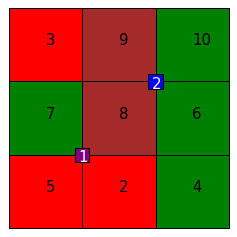

In [12]:
board.draw()


## Rules
When implementing the game, remember to follow these rules:
<ul>
<li> Every turn you roll 2 dice, call the sum X </li>
<li> Find tiles labeled with the number X and collect one of that resource for every settlement and two of that resource for every city on a vertex of that tile (this logic is implemented for you already) </li>
<li> You can never have more than 4 of any resource: if you get extra, you just keep 4 </li>
<li> You can trade 4 resources of the same kind for a resource of your choice (i.e. 4 grain for 1 wood) </li>
<li> You can build by paying resources according to the costs below, and building anything gives you 1 victory point </li>
<li> You start the game off with 4 of each resource and no buildings
</ul>

## Costs
You can build villages, which boost your production (but bring no victory points), or buy development cards which can bring you an additional victory point.

The costs are given below, and stored in the array costs for convenience.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

costs = np.array([[2, 3, 1],
                  [1, 1, 2],
                  [4, 2, 2]])

resources = ['wood', 'brick', 'grain']
buildings = ['settlement', 'card', 'city']
df = pd.DataFrame(costs, index=buildings, columns=resources)
html = df.to_html()
from IPython.core.display import HTML
HTML(html)

,wood,brick,grain
settlement,2,3,1
card,1,1,2
city,4,2,2


The Catan board is implemented for you, with utilities to draw and get a table of resources gained. In particular you will find these two functions useful:

 
Here's a short API of the classes and methods implemented in catan.py (which you're encouraged to check out):

#### BOARD CLASS

To initialize a board: 
`board = Catan(dice, resources, settlements, cities)`

The constructor initializes our Catan board. Dice and resources must be the same shape: HxW where H is the height of the board and W is the width. dice[i,j] is the dice number that tile corresponds to (each element between 2-12 inclusive) and resources[i,j] is the resource that tile  provides. Settlements is a list of vertices with settlements on them, and likewise for cities.

`board.build(x,y,building)`
takes in two coordinates, x and y, along with a building type ("city"/"settlement") and builds that building at the specified location. If the building cannot be built at that location, an exception is thrown.

`board.if_can_build(building,x,y)`
returns False if a building cannot be build at that stop. Otherwise, it returns True.

`board.get_resources()`
returns a 11x3 numpy array of resources gained for each possible dice sum. That is, r[i, :] = resources gained from throwing a (i+2).

`board.draw()`
draws the board


#### PLAYER CLASS

`player = Player(action,board,resources,points=0,turn_counter=0)`
Where a board is a Catan board, an action is a function, resources is an array, points and turn_counter are integers used for debugging.

`player.if_can_buy(item)` 
returns True if the player can afford item ("card"/"settlement"/"city") and False otherwise

`player.buy(item)` 
actually buys the item and throws a CatanException if that is not possible.

`player.play_round()` 
plays one round of Catan: rolls the dice, collects the resources and calls the function action()

[[ 2.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  2.  0.]
 [ 0.  0.  2.]
 [ 0.  0.  1.]
 [ 0.  1.  0.]
 [ 0.  0.  3.]
 [ 1.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]


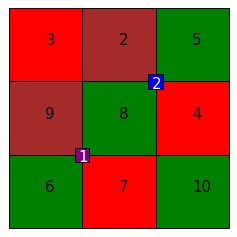

In [4]:
board.draw()
print board.get_resources()
# wood is brown, brick is red, grain is green
# below is the resource outcome of a dice roll

Below are a few more utility functions you may use to handle converting state triplets into integers.

In [5]:
# hand = (w, b, g)
LIMIT = 5 # can have 0-4 of each resource

def encode(w, b, g):
    return LIMIT * LIMIT * w + LIMIT * b + g

def decode(n):
    x = n % (LIMIT * LIMIT)
    return (n // (LIMIT * LIMIT), x // LIMIT, x % LIMIT)

In [6]:
l = np.array((LIMIT-1, LIMIT-1, LIMIT-1))
def floor(state):
    return np.minimum(l, state)

## Optimal Actions

Below is a "policy" for acting on the board: given the board (self.board) and current resources, the function returns your action this turn.

In [7]:
# sample strategy function     

def action(self, resources, costs):
    # inputs:
    # resources - an array of resources
    # costs - an array of costs, 0 - settlement, 1 - card, 2 - city
    # basic strategy: Once we get 4 of one resource and less than 2 of any other, we make a trade. 
    # Then we try to buy development cards
#     if self.board.settlements == []:
#         x = np.random.randint(0, self.board.width + 1)
#         y = np.random.randint(0, self.board.height + 1)
#         self.board.build(x, y, "settlement")
#     if self.if_can_buy("card"):
#         self.buy("card")
#     elif self.resources[np.argmax(self.resources)] >= 4 and self.resources[np.argmin(self.resources)] < 2:
#         rmax, rmin = np.argmax(self.resources), np.argmin(self.resources)
#         self.resources[rmax] -= 4
#         self.resources[rmin] += 1
#     return
    

num_trials = 100
print simulate_game(action, board, num_trials)

IndentationError: expected an indented block (<ipython-input-7-5ac06086fd3b>, line 22)

In [61]:
num_trials = 100
dice = get_random_dice_arrangement(4, 4)
resources = np.random.randint(0, 3, (4, 4))
myBoard = Catan(dice, resources, [6], [])

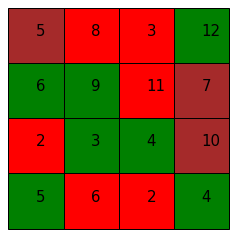

In [104]:
def expectedTime(board, building, bank):
    ### your code here
    costs = np.array([[2, 3, 1],
                  [1, 1, 2],
                  [4, 2, 2]])
    resources = board.get_resources()
    probabilities = [1.0/36, 2.0/36, 3.0/36, 4.0/36, 5.0/36, 6.0/36, 5.0/36, 4.0/36, 3.0/36, 2.0/36, 1.0/36]
    expectations = [0, 0, 0]
    for i in range(3):
        for j in range(11):
            expectations[i] += float(probabilities[j])*float(resources[j][i])
    needed = costs[building]
    for i in range(3):
        if bank[i] > needed[i]:
            needed[i] = 0
        else:
            needed[i] = needed[i] - bank[i]
    #print("needed: ")
#     print(needed)
    #print("expectations: ")
    #print(expectations)
    minimum = float("inf")
    best = [0,0,0]
    def helper(index, implicit):
        if index==implicit:
            return float(needed[index])
        else:
            return float(needed[implicit])*4.0
    for i in range(3):
        for j in range(3):
            for k in range(3):
                if expectations[i]==0 or expectations[j]==0 or expectations[k]==0:
                    continue
                if i==j and j==k:
                    x = helper(i, 0)/expectations[i] + helper(j, 1)/expectations[j] + helper(k, 2)/expectations[k]
                elif i==j:
                    x = max(helper(i,0)/expectations[i]+helper(j,1)/expectations[j], helper(k,2)/expectations[k])
                elif j==k:
                    x = max(helper(k,2)/expectations[k]+helper(j,1)/expectations[j], helper(i,0)/expectations[i])
                elif i==k:
                    x = max(helper(i,0)/expectations[i]+helper(k,2)/expectations[k], helper(j,1)/expectations[j])
                else:
                    x = max(helper(i,0)/expectations[i], helper(j,1)/expectations[j], helper(k,2)/expectations[k])
#                 print "at point: {} x is {}".format((i,j,k),x)
                if x < minimum:
                    minimum = x
                    best = [i,j,k]
    #print("best: ")
    #print(best)
    return (minimum)

min = expectedTime(myBoard, 1, [0,0,2])
# print min
myBoard.draw()

checking settlement
[0]
checking settlement
[5]
checking settlement
[10]
checking settlement
[15]
checking settlement
[20]
checking settlement
[1]
checking settlement
[6]
checking settlement
[11]
checking settlement
[16]
checking settlement
[21]
checking settlement
[2]
checking settlement
[7]
checking settlement
[12]
checking settlement
[17]
checking settlement
[22]
checking settlement
[3]
checking settlement
[8]
checking settlement
[13]
checking settlement
[18]
checking settlement
[23]
checking settlement
[4]
checking settlement
[9]
checking settlement
[14]
checking settlement
[19]
checking settlement
[24]
(2, 2)


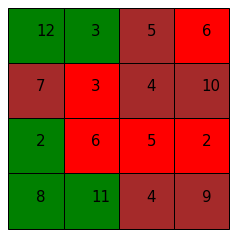

In [109]:
def settlementStrategy(board, currentBuild, desiredBuild, resources):
    # self - the catan player instance
    #     if_can_buy(item) -- returns boolean if you can buy item. Item = {"card", "settlement", "city"}
    #     buy(item) -- buys item. Item = {"card", "settlement", "city"}
    #     play_round() -- plays a round of catan and returns the dice roll and increments your resources
    # resources - the amount of resources you have at a given turn
    # costs - a 3x3 array
    #     row 0 is cost for settlement, 2 wood, 3 brick, 1 grain
    #     row 1 is cost for card, 1 wood, 1 brick, 2 grain
    #     row 2 is cost for city, 4 wood, 2 brick, 2 grain
    # USE: some outside strategy determines it is a good time to build currentBuild (settlement or city). It also
    # determines that it would like to place the currentBuild build such that it optimizes resource aquirement for
    # building desiredBuild. This function finds the best place to build currentBuild such that resource aquirement 
    # for desiredBuild is optimized
    # Returns: Best location to build currentBuild such that the time it takes to get the resources necessary to build
    #          desiredBuild is minimized
    if currentBuild == 1:
        return "DON'T PASS IN A DEVELOPMENT CARD BITCH"
    bestScore = float("inf")
    bestIndex = (0,0)
    for i in range(0, board.width+1):
        for j in range(0, board.height+1):
            if board.if_can_build(currentBuild, i,j) and currentBuild == 0:
                print "checking settlement"
                newlst = board.settlements + [board.get_vertex_number(i,j)]
                testBoard = Catan(board.dice, board.resources, newlst, board.cities)
                print newlst # enforce that you lose resources after building settlement
                testScore = expectedTime(testBoard, desiredBuild, resources)# next thing we build will be a settlement 
                if testScore < bestScore:
                    bestScore = testScore
                    bestIndex = (i,j)
            elif board.if_can_build(currentBuild, i,j)and currentBuild == 2:
                print "checking city"
                newlst = board.cities + [board.get_vertex_number(i,j)]
                testBoard = Catan(board.dice, board.resources, board.settlements, newlst)
                print newlst
                testScore = expectedTime(testBoard, desiredBuild, resources) # next thing we build will be a settlement 
                if testScore < bestScore:
                    bestScore = testScore
                    bestIndex = (i,j)
    return bestIndex

num_trials = 100
dice = get_random_dice_arrangement(4, 4)
resources = np.random.randint(0, 3, (4, 4))
myBoard = Catan(dice, resources, [], [])
myBoard.draw()
print settlementStrategy(myBoard, 0,0, [2,1,3])



Experiment with your own action function, simulate the results and try to come up with a good one... then report your expected time to win and simulation results using this policy.

##  <font color=blue> Efficient Optimization [OPTIONAL] </font>

In the final phase of the project, use the tools you wrote above to figure out the best action sequence to minimize the time until you reach 10 points. To make our calculations tractable we can compute something a little different than finding the optimum action over all actions and all possible game states. Instead, we can reduce the goal at any given moment to building the _next_ objective. In this framework, we need to minimize the expected time from having no resources to building each objective. The below questions are optional but we recommend doing it to see the topics we cover in class from a computing point of view, and it can be part of your "extension" to the project.

### <font color=blue> 1. Create a function `get_transition_matrix` which returns the transition matrix of your Markov chain. </font>

In [48]:
def transition_matrix(board):
    """returns matrix T[i, j] = P(transition from state i to state j)"""
    ### Fill in your solution here
    LIMIT = 5
#     width = LIMIT**3
#     T = np.zeros((width,width))
#     for i in range(width):
#         for j in range(width):
    return np.zeros(1)
            
    

T = transition_matrix(board)
print T

[ 0.]


##  <font color=blue> Calculating Hitting Time</font>

Let's start by building a useful function to answer the question: given a board layout and starting resources, how long will it take until you can afford a specific building?

Hint: one method would be to create another Markov chain/transition matrix where the hitting time between two of the states gives the time until you can afford a building.

### <font color=blue> 2a. Write a function to calculate mean hitting time from 0 resources until you can afford a building.

In [9]:
def hitting_time(board, building):
    ### your code here
    costs = np.array([[2, 3, 1],
                  [1, 1, 2],
                  [4, 2, 2]])
    resources = board.get_resources()
    probabilities = [1.0/36, 2.0/36, 3.0/36, 4.0/36, 5.0/36, 6.0/36, 5.0/36, 4.0/36, 3.0/36, 2.0/36, 1.0/36]
    expectations = [0, 0, 0]
    for i in range(3):
        for j in range(11):
            expectations[i] += float(probabilities[j])*float(resources[j][i])
    needed = costs[building]
    results = [0,0,0]
    print(needed)
    print(expectations)
    for i in range(3):
        if expectations[i] == 0:
            results[i] = min(expectations[(i+1)%3]*4*needed[i]+expectations[i])
        results[i] = needed[i]*expectations[i]
    return max(results)
    
h = hitting_time(board, 1) # calculates time until we can afford a VP card
print h

[1 1 2]
[0.16666666666666666, 0.3333333333333333, 0.7777777777777778]
1.55555555556


### <font color=blue> 2b. Simulate the Markov process and record the expected hitting time to states to check the accuracy of your hitting time function. </font>

In [ ]:
# simulator goes here


Now you can minimize total expected hitting time with your policy using your hitting time function to speed up the optimization instead of simulating everything.